# CMIP6 Compute WUE

**Following steps are included in this script:**

1. Load netCDF files
2. Compute WUE
3. Save and replace netcdf files

In [1]:
# ========== Packages ==========
import sys
import os
import xarray as xr
import numpy as np
import dask
from dask.diagnostics import ProgressBar
import importlib
import copy

# Define the full path to the data_handling directory and the config file
data_handling_dir = '/work/ch0636/g300115/phd_project/common/src/data_handling'
config_dir = '/work/ch0636/g300115/phd_project/common/src'

# Add the directories to sys.path
sys.path.append(data_handling_dir)
sys.path.append(config_dir)

# Now import the functions from load_preprocessed_data.py and config
import load_data as ld
import save_data_as_nc as sd
from config import BASE_DIR, DEFAULT_MODEL, DEFAULT_VARIABLE, DEFAULT_TEMPORAL_RES, DEFAULT_EXPERIMENT

### Functions

In [60]:
def convert_units_wue(ds, var_name, target_units):
    """
    Convert units of a variable to the target units if necessary.

    Parameters:
    ds (xarray.Dataset): The dataset containing the variable.
    var_name (str): The name of the variable to convert.
    target_units (str): The target units ('mm/day' or 'gC/m²/day').

    Returns:
    xarray.DataArray: The variable with converted units.
    """
    var = ds[var_name]
    if 'units' in var.attrs:
        current_units = var.attrs['units']
        if var_name == 'tran' and current_units != target_units:
            if current_units == 'kg/m²/s':
                var = var * 86400  # Convert from kg/m²/s to mm/day
                var.attrs['units'] = 'mm/day'
        elif var_name == 'gpp' and current_units != target_units:
            # Assuming gpp might be in other units, add conversion logic if needed
            pass
        var.attrs['units'] = target_units
    return var

def compute_wue(ds_dict, wue_threshold=10):
    """
    Compute the Water Use Efficiency (WUE) for each dataset in the dictionary.

    Parameters:
    ds_dict (dict): Dictionary of datasets, each containing 'tran' (transpiration) and 'gpp' (gross primary production).
    wue_threshold (float): The maximum realistic value for WUE, above which values will be set to NaN.

    Returns:
    dict: Updated dictionary with WUE included in each dataset.
    """
    ds_dict_copy = copy.deepcopy(ds_dict)
    models_with_wue = []
    realistic_range = (0.1, 5)  # Set a realistic range for WUE values in gC/m²/mm
    
    for name, ds in ds_dict_copy.items():
        # Check if all required variables are present
        required_vars = ['tran', 'gpp']
        missing_vars = [var for var in required_vars if var not in ds]
        
        if missing_vars:
            print(f'WUE not computed for {name} as variable(s) {", ".join(missing_vars)} is/are missing')
            continue
        
        # Convert units if necessary
        ds['tran'] = convert_units_wue(ds, 'tran', 'mm/day')
        ds['gpp'] = convert_units_wue(ds, 'gpp', 'gC/m²/day')
        
        # Compute WUE
        #wue = ds['gpp'] / ds['tran']

        # Resample to yearly sums (assuming 'time' is the dimension in your dataset)
        yearly_gpp = ds['gpp'].resample(time='1Y').sum(dim='time')
        yearly_tran = ds['tran'].resample(time='1Y').sum(dim='time')
        
        # Compute WUE using the yearly sums
        wue_yearly = yearly_gpp / yearly_tran
        
        # Optionally, you can set a threshold to remove extreme values
        wue = xr.where(wue_yearly > wue_threshold, np.nan, wue_yearly)
        
        # Apply threshold to WUE values
        #wue = xr.where(wue > wue_threshold, np.nan, wue)
        
        # Assign attributes to the WUE variable
        attrs = {
            "description": "This dataset contains the Water Use Efficiency (WUE) computed from gross primary production (gpp) and transpiration (tran).",
            "units": "gC/m²/mm",
            "long_name": "Water Use Efficiency",
            "calculation": f"WUE was computed using the formula WUE = gpp / tran with WUE values above {wue_threshold} gC/m²/mm set to NaN.",
            "source": "Data sourced from the CMIP6 archive.",
        }
        
        # Create new dataset containing only WUE
        wue_var = xr.DataArray(wue, dims=ds['tran'].dims, attrs=attrs)
        ds_wue = xr.Dataset({'wue': wue_var})
        
        # Replace the old dataset with the new one
        ds_dict_copy[name] = ds_wue
        models_with_wue.append(name)
        
        print(f'WUE computed and saved for {name}')
    
    # Check global means to ensure no model is significantly off
    for name in models_with_wue:
        ds = ds_dict_copy[name]
        global_mean_wue = ds['wue'].mean().item()
        print(f'Global mean WUE for {name}: {global_mean_wue}')
        
        # Check if global mean WUE is within realistic range
        if not (realistic_range[0] <= global_mean_wue <= realistic_range[1]):
            print(f'WARNING: Global mean WUE for {name} is {global_mean_wue}, which is outside the realistic range of {realistic_range[0]} to {realistic_range[1]} gC/m²/mm.')
        
    return ds_dict_copy

### 1. Load netCDF files

In [3]:
# ========= Define period, models and path ==============
data_state = 'processed'
data_product = 'CMIP6'
experiments = ['ssp370']
temp_res = 'month'
models = ['CESM2', 'CMCC-CM2-SR5', 'IPSL-CM6A-LR']#['BCC-CSM2-MR', 'CAMS-CSM1-0', 'CESM2-WACCM', 'CNRM-ESM2-1', 'GISS-E2-1-G', 'MIROC-ES2L', 'NorESM2-MM', 'UKESM1-0-LL', 'CanESM5', 'CNRM-CM6-1', 'GFDL-ESM4', 'MPI-ESM1-2-LR', 'TaiESM1']
variables=['gpp', 'tran'] 
           
# Execute load function with Dask
with ProgressBar():
    ds_dict = dask.compute(ld.load_multiple_models_and_experiments(BASE_DIR, data_state, data_product, experiments, temp_res, models, variables))[0]

[########################################] | 100% Completed | 1.61 sms


In [79]:
 # Resample to yearly sums (assuming 'time' is the dimension in your dataset)
yearly_gpp = ds_dict[list(ds_dict.keys())[0]][models[0]]['gpp'].sum(dim='time')
yearly_tran = ds_dict[list(ds_dict.keys())[0]][models[0]]['tran'].sum(dim='time')

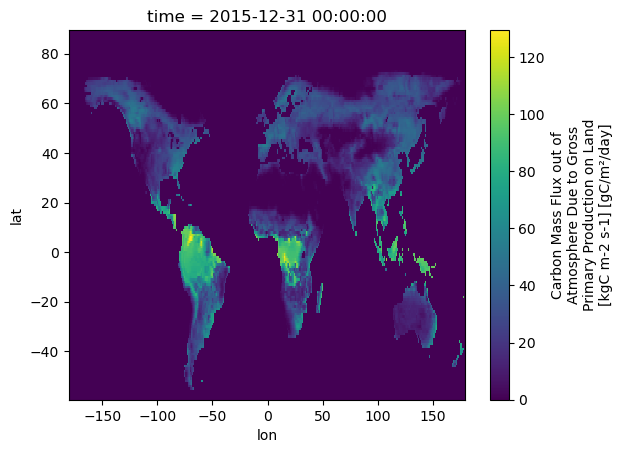

In [65]:
yearly_gpp.isel(time=0).plot()

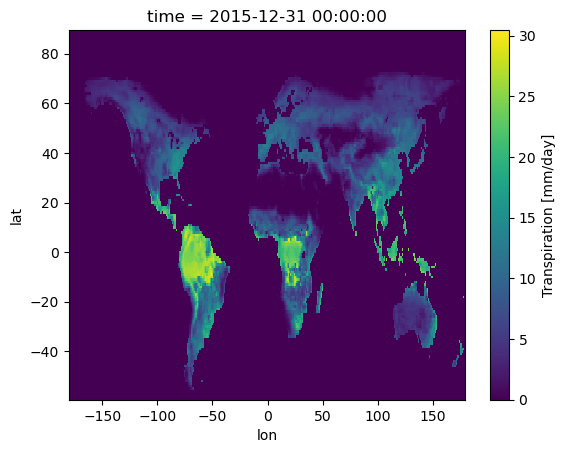

In [66]:
yearly_tran.isel(time=0).plot()

In [82]:
yearly_gpp.mean()

<xarray.DataArray 'gpp' ()>
array(717.97943, dtype=float32)

In [83]:
yearly_tran.mean()

<xarray.DataArray 'tran' ()>
array(151.27312, dtype=float32)

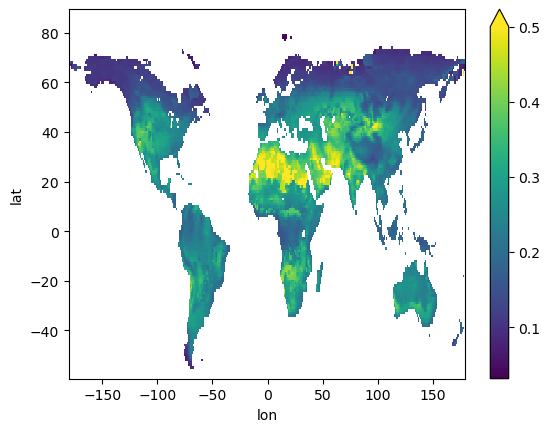

In [86]:
(yearly_tran/yearly_gpp).plot(vmax=0.5)

['ssp370']


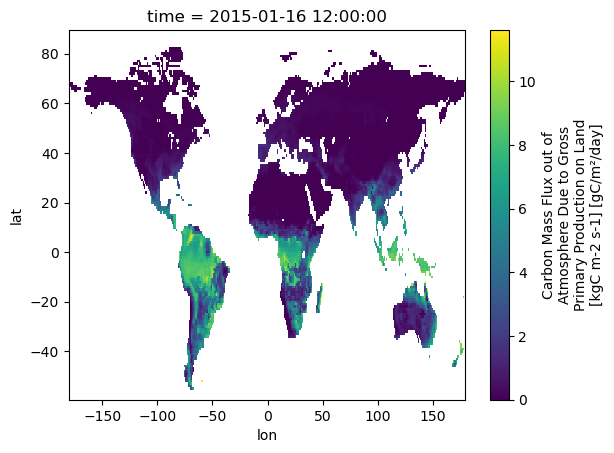

In [54]:
# ========= Have a look into the dictionary =======
print(list(ds_dict.keys()))
ds_dict[list(ds_dict.keys())[0]][models[0]][variables[0]].isel(time=0).plot()

### 2. Compute WUE

In [61]:
updated_ds_dict = {}
updated_ds_dict = compute_wue(ds_dict[experiments[0]])

WUE computed and saved for CESM2
WUE computed and saved for CMCC-CM2-SR5
WUE computed and saved for IPSL-CM6A-LR
Global mean WUE for CESM2: 4.370810031890869
Global mean WUE for CMCC-CM2-SR5: 3.539947032928467
Global mean WUE for IPSL-CM6A-LR: 4.370746612548828


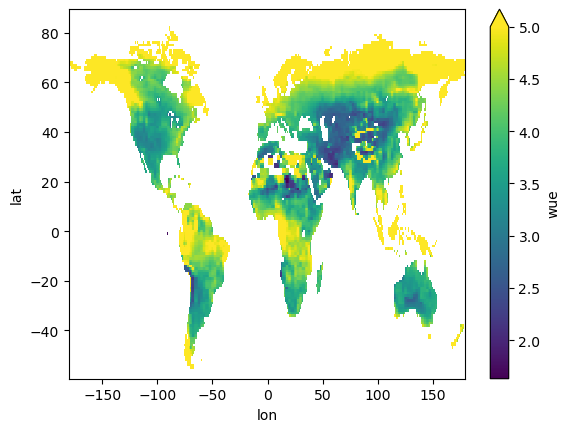

In [62]:
updated_ds_dict[models[2]]['wue'].mean('time').plot(vmax=5)

['CESM2', 'CMCC-CM2-SR5', 'IPSL-CM6A-LR']


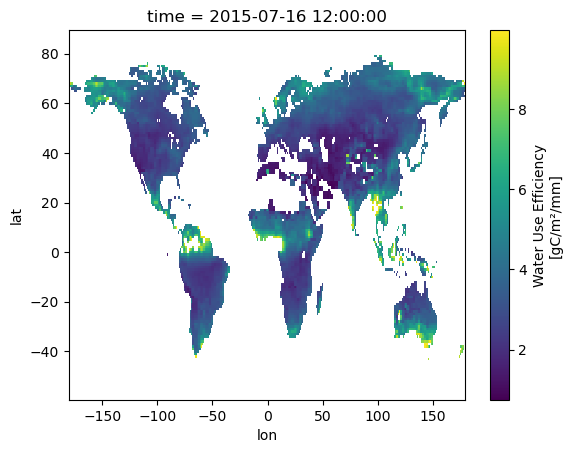

In [34]:
# ========= Have a look into the dictionary =======
print(list(updated_ds_dict.keys()))
updated_ds_dict[models[2]]['wue'].isel(time=6).plot()

### 3. Save and replace netcdf files¶

In [43]:
# =========== Store file and remove any former one ==========
# Base directory
data_path = f'{data_state}/{data_product}/{experiments[0]}/{temp_res}/'
file_path = os.path.join(BASE_DIR, data_path)
print(file_path)

/work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/


In [44]:
sd.save_files(updated_ds_dict, file_path)

File saved at: /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/wue/CESM2.nc
File saved at: /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/wue/CMCC-CM2-SR5.nc
File saved at: /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/wue/IPSL-CM6A-LR.nc
